# Basic Functions

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt

In [2]:
def plot_activity(X, t, bins=20, cutoff_div=None):
    if cutoff_div is not None:
        data = np.array_split(
            np.concatenate([X[: len(X) // cutoff_div + 2], X[-len(X) // cutoff_div :]]),
            bins,
            axis=0,
        )
        t_data = np.array_split(
            np.concatenate([t[:len(X) // cutoff_div + 2], t[-len(X) // cutoff_div :]]),
            bins
        )
    else:
        data = np.array_split(X, bins, axis=0)
        t_data = np.array_split(t, bins)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, bins, figsize=(25, 8), sharey=False)

    # Iterate over the subplots and plot the corresponding data
    for i, ax in enumerate(axs):
        ax.imshow(data[i][::], vmax=X.max(), vmin=X.min(),
                  #extent=[0, 20, 2*N, 0])
                  extent=[0, N/len(data[i])*(t_data[i][-1]-t_data[i][0]), t_data[i][-1], t_data[i][0]])
        ax.set_xticks([])
        ax.set_xlabel('$x$')
    axs[0].set_ylabel("time (s)", fontsize=15)
    plt.subplots_adjust(wspace=-0.2)
    plt.tight_layout()
    plt.show()

In [3]:
def u(t, T, scale=5000):
    return scale * np.sin(2 * np.pi * t / T)

In [118]:
# nonlinearity
def phi(x, scale=1):
    return 1 / (1 + np.exp(np.maximum(-250, np.minimum(250, -scale * x))))


def f_I_matrix_multiply(w, x):
    return w @ x


def get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=True):
    I_in = f_I(w, X[i - delay_i])
    return (-X[i - 1] + phi(int(train) * u(t[i] + theta, T) + I_in)) * dt * alpha


def get_dw(X, dx, w, i, beta, lmbda, delay_i, dt):
    return (-lmbda * w + np.outer(dx / dt, X[i - delay_i])) * dt * beta  # post <- pre

In [119]:
def simulate(
    dt,
    N,
    T,
    t,
    theta,
    alpha,
    beta,
    delay_i,
    lmbda,
    w,
    get_dw,
    get_dx,
    f_I,
    phi,
    u,
    train=True,
    full_info=True,
    init_stimulation=True,
    init_travel=1,
):
    N_STEPS = len(t)
    X = np.zeros((N_STEPS, N))
    W = [w.copy()]
    DW = []
    DX = []

    if init_travel == 0:
        init_duration = delay_i
        t_init = np.zeros(delay_i)
    else:
        init_duration = 0
        while init_duration <= delay_i:
            init_duration += abs(round(N / init_travel))
        if init_travel > 0:
            t_init = np.arange(0, init_duration, init_travel*dt)
        else:
            t_init = np.arange(init_duration, 0, init_travel*dt)
        
    
    for i in range(1, init_duration):
        dx = get_dx(
            X, w, i, lambda w, x: 0, phi, u, alpha, theta, t_init,
            delay_i, T, dt, train=init_stimulation
        )
        X[i] = X[i - 1] + dx
    
        if full_info:
            W.append(w.copy())
            DW.append(np.zeros(N))
            DX.append(dx.copy())

    for i in range(init_duration, N_STEPS):
        dx = get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=train)
        dw = get_dw(X, dx, w, i, beta, lmbda, delay_i, dt)

        # Update the neuronal activity
        X[i] = X[i - 1] + dx

        # Update the synaptic weights
        w += dw

        if full_info:
            W.append(w.copy())
            DW.append(dw.copy())
            DX.append(dx.copy())
    if full_info:
        return X, w, np.array(W), np.array(DW), np.array(DX)
    else:
        return X, w

# Constants

In [136]:
dt = 2e-3
N = 500  # number of neurons
T = N * dt  # period, in seconds

rolling_indices = np.array([np.roll(np.arange(N), -i) for i in range(N)])

simulation_duration = 50 * T
t = np.arange(0, simulation_duration, dt)

theta = np.linspace(0, T, N, endpoint=False)  # spatial variable for neurons

# time constants, in seconds
tau_x = 20 * 1e-3
alpha = 1 / tau_x

tau_d = 15 * 1e-3
delay_i = round(tau_d / dt)

tau_w = 2000 * 1e-3
beta = 1 / tau_w

lmbda = 20

# Full Connectivity Simulation

$$
\text{input current \hspace{0.2cm}} u(x, t) = u(x, t + T) = u(0, t+x)
$$

$$
\text{firing rate \hspace{0.1cm}} r(x, t)
$$
$$
\tau_r \frac{\partial}{\partial t} r(x, t) = -r(x, t) + \varphi\bigg(u(x, t) + \int_0^T w(x, y, t) r(y, t - \tau_d) dy\bigg)
$$

$$
\text{learned weights \hspace{0.1cm}} \lim_{t\to \infty} w(\Delta x, t)
$$

$$
\text{learned weights from $y$ to $x$ \hspace{0.1cm}} \lim_{t\to \infty} w(x, y, t)
$$
$$
\tau_w \frac{\partial}{\partial t} w(x, y, t) = {r}(y, t-\tau_d)\dot{r}(x, t) - \lambda {w}(x, y, t)
$$

In [137]:
w_full = 0.05 * np.random.randn(N, N)

X_full, w_full = simulate(
    dt,
    N,
    T,
    t,
    theta,
    alpha,
    beta,
    delay_i,
    lmbda,
    w_full,
    get_dw,
    get_dx,
    f_I_matrix_multiply,
    phi,
    u,
    full_info=False,
)

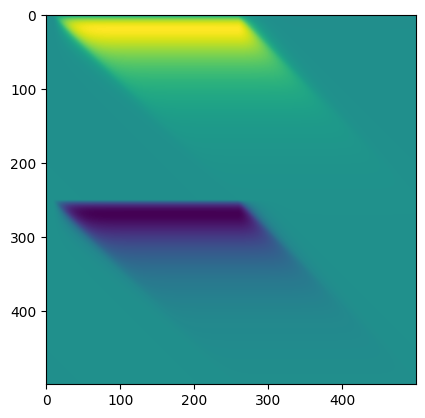

In [141]:
plt.imshow(w_full)

Text(0, 0.5, '$t$')

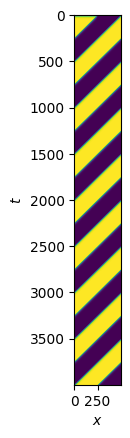

In [139]:
plt.imshow(X_full[:4000])
plt.xlabel("$x$")
plt.ylabel("$t$")

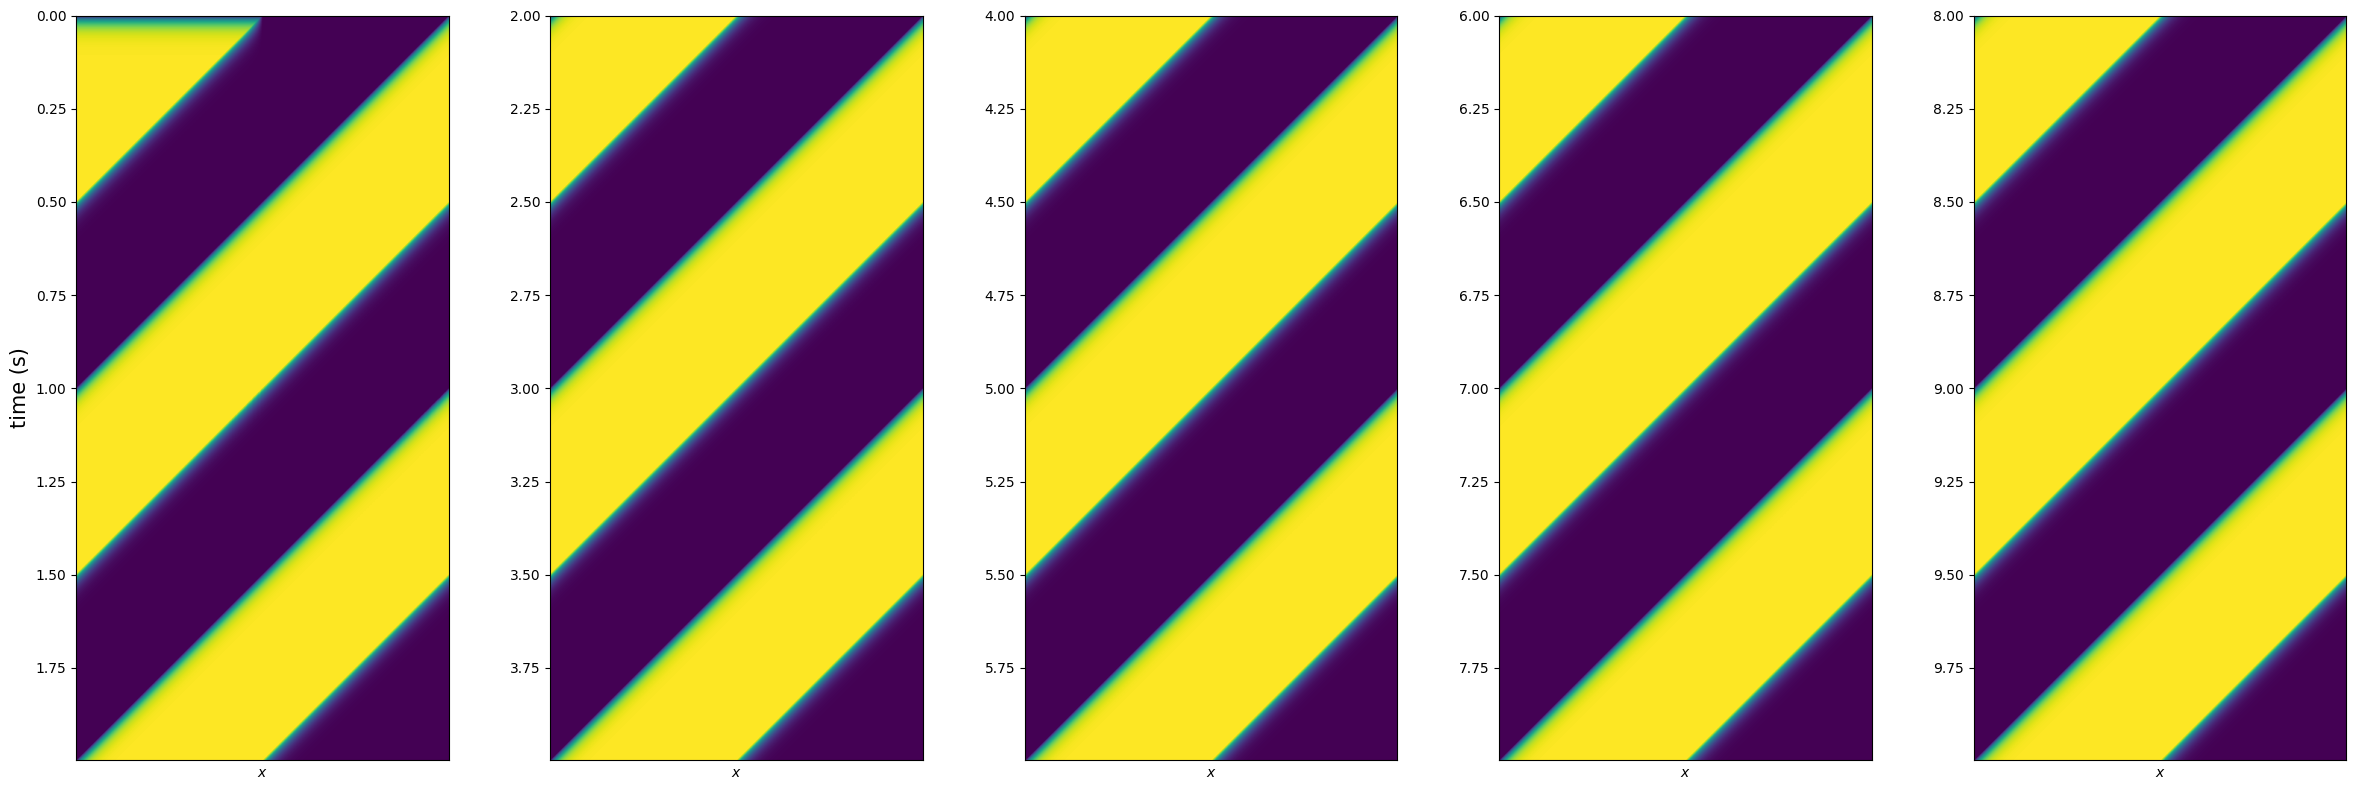

In [140]:
plot_activity(X_full[:10*N], t[:10*N], bins=5)

# Weight Symmetry

We observe a periodicity of network activity and synaptic weights.

In [12]:
def symmetrize(A, mod):
    return np.array(
        [np.roll(row, -round(N * i / mod % mod)) for i, row in enumerate(A)]
    )

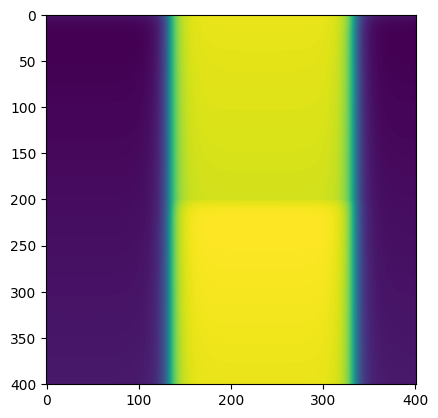

In [13]:
plt.imshow(symmetrize(w_full, N));

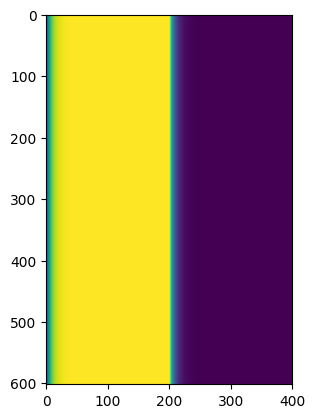

In [14]:
plt.imshow(symmetrize(X_full[-round(1.5 * N) :], -N));

In [15]:
def f_I_conv_circ(signal, ker):
    return np.array(
        [np.sum(signal * np.roll(ker[::-1], n)) for n in range(1, len(signal) + 1)]
    )

def f_I_conv_circ_fft(signal, ker):
    return np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(ker)))

In [16]:
w_ = w_full[:, 0]

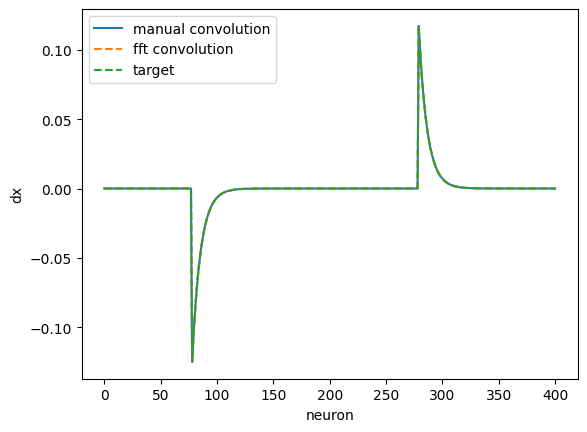

In [17]:
i_ = 123
plt.plot(
    get_dx(X_full, w_, i_, f_I_conv_circ, phi, u, alpha, theta, t, delay_i, T, dt),
    label="manual convolution",
)
plt.plot(
    get_dx(X_full, w_, i_, f_I_conv_circ_fft, phi, u, alpha, theta, t, delay_i, T, dt),
    linestyle="dashed",
    label="fft convolution",
)
plt.plot(
    get_dx(
        X_full, w_full, i_, f_I_matrix_multiply, phi, u, alpha, theta, t, delay_i, T, dt
    ),
    linestyle="dashed",
    label="target",
)
plt.ylabel("dx")
plt.xlabel("neuron")
plt.legend();

In [18]:
def get_dw_prime(X, dx, w, i, beta, lmbda, delay_i, dt):
    return (-lmbda * w + X[i - delay_i, 0] * (dx / dt)) * dt * beta

In [19]:
def get_dw_prime_mean(X, dx, w, i, beta, lmbda, delay_i, dt):
    return (
        (
            -lmbda * w * dt
            + (dx[rolling_indices] * X[i - delay_i][:, None]).mean(0)
        )
        * beta
    )

In [20]:
%%time
w_ = 0.005 * np.random.randn(N)

X, w_, W = simulate(
    dt,
    N,
    T,
    t,
    theta,
    alpha,
    beta,
    delay_i,
    lmbda,
    w_,
    get_dw_prime_mean,
    get_dx,
    f_I_conv_circ_fft,
    phi,
    u,
    full_info=False,
)

CPU times: user 10.1 s, sys: 54.5 ms, total: 10.2 s
Wall time: 10.2 s


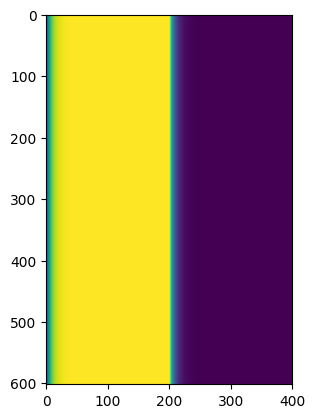

In [21]:
plt.imshow(symmetrize(X[-round(1.5 * N) :], -N));

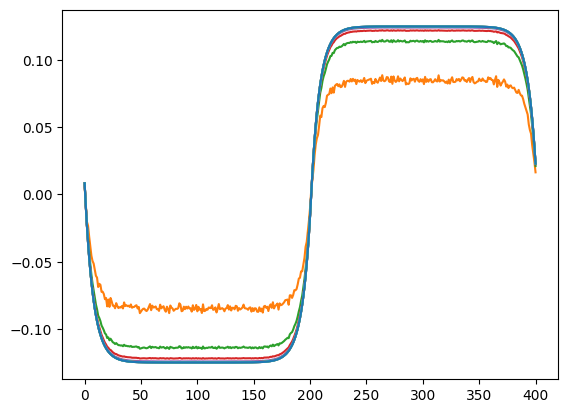

In [22]:
plt.plot(np.roll(W[:].T, delay_i, axis=0));

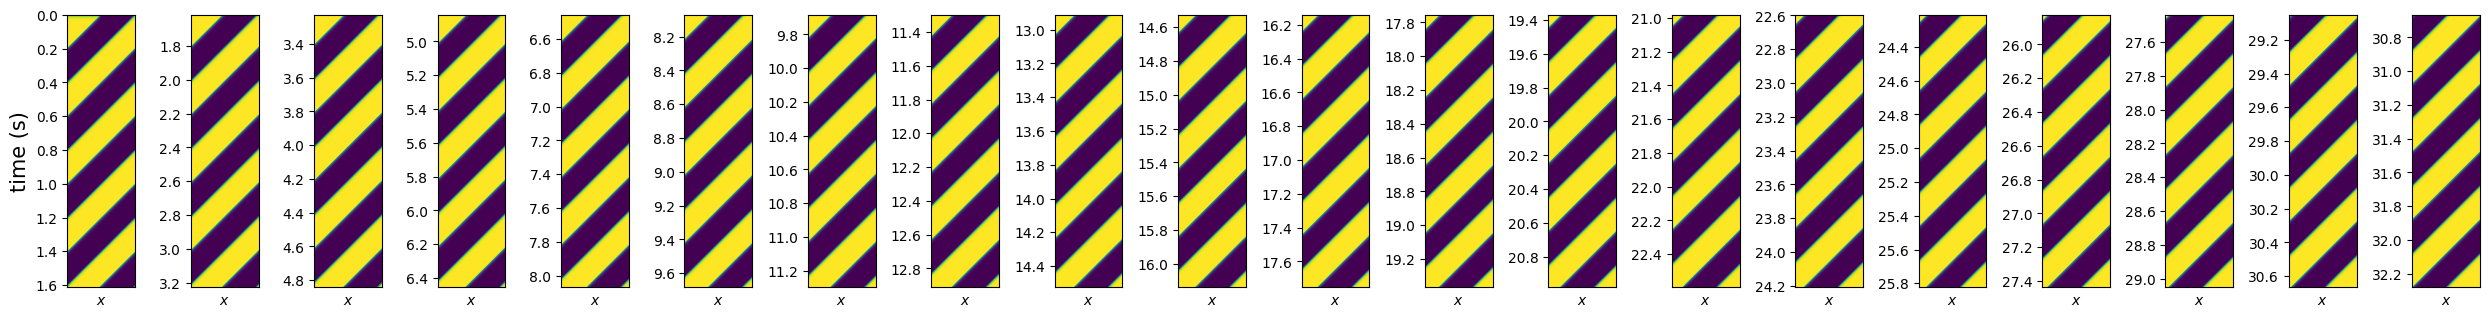

In [23]:
plot_activity(X, t)

In [24]:
X[-1000:].max(), X[-1000:].min()

(0.9999999999974788, 2.5212191793764385e-12)